In [19]:
import os
import sys
import smbus

from math import log
from time import sleep
from datetime import datetime

import matplotlib.pyplot as plt

In [2]:
# get current working directory and append relative path for package import
if os.name == 'posix':
    _wd = !pwd
    _wd = _wd[0]
elif os.name == 'nt':
    _wd = !cd
    _wd = _wd[0]
else:
    _wd = os.getcwd()
print('Current working directory is:', _wd)
p = os.path.dirname(_wd)
p = os.path.join(p, '.')
p = os.path.abspath(p)
print('Appending directory to path:', p)
sys.path.insert(0, p)

# alternatively, manually set the path to meerkat
#sys.path.insert(0, '/path_to_meerkat')

Current working directory is: /home/colin/code/meerkat/examples
Appending directory to path: /home/colin/code/meerkat


In [3]:
from meerkat import ads

In [4]:
i2c = smbus.SMBus(1)
dev = ads.ADS1115(bus=i2c)
dev.get_config()
dev.pga('6.144')

In [5]:
dev.print_attributes()

ADS11x5 Configuration Attributes
--------------------------------
Config Register: 33024 0x8100 0b1000000100000000
PGA Range: +/- 6.144 Volts
Mode: single
Data Rate: 8 SPS
Input Multiplexer: 01
Comparator:
 Queue: 1
 Latching: off
 Polarity: Active 1
 Mode: trad


In [6]:
def get_time():
    return datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')

In [7]:
def R2(R1, Vin, Vout):
    """Voltage divider, unknown resistance with known resistance and voltages"""
    return R1 * (1 / ((Vin/Vout) - 1))

In [8]:
def steinhart_hart_equation(r, a, b, c):
    """Calculate temperature in Kelvin from a resistance
    based on the Steinhart–Hart equation

    Parameters
    ----------
    r : float, resistance of thermister
    a : float, coeffient
    b : float, coeffient
    c : float, coeffient

    Returns
    -------
    t : float, temperature in Kelvin
    """
    return 1.0 / (a + b * log(r) + c * (log(r) ** 3))
    
def kelvin_to_celcius(k):
    """Convert temperature in Kelvin to Celsius

    Parameters
    ----------

    k : float, temperature in degrees Kelvin
    Returns
    -------
    float, temperature in degrees Celsius
    """
    return k - 273.15

In [9]:
import time

In [10]:
dev.delay = 0.1

In [42]:
# Rough pass at temperature
# delay between reads and writes sometimes need to be increased
dev.delay = 0.1

# get voltages of pins
dev.mux('1G')     # pin 0 relative to ground
Vcc = dev.voltage()
time.sleep(1)
print('Measured Source voltage: {} V'.format(Vcc))
dev.mux('2G')     # pin 1 relative to ground
Vt = dev.voltage()
print('Measured Thermistor voltage: {} V'.format(Vt))

# calculate resistance of thermistor
Rt = R2(R1=10000, Vin=Vcc, Vout=Vt)
print('Measured resistance: {} ohms'.format(Rt))

# Thermistor is a Semitec 103AT-2 values from datasheet

a = 0.000811290160145459
b = 0.000211355789144265
c = 7.17614730463848e-08

a = 0.001129148
b = 0.000234125
c = 8.76741e-08

tK = steinhart_hart_equation(Rt, a, b, c)
tC = kelvin_to_celcius(tK)
print('Measured temperature: {:6.2f} C'.format(tC))

Measured Source voltage: 2.04825 V
Measured Thermistor voltage: 0.9751875 V
Measured resistance: 9087.890966276429 ohms
Measured temperature:  27.19 C


In [14]:
tt = list(range(-50, 115, 5))

In [28]:
r103AT = [329.5, 247.7, 188.5, 144.1, 111.3, 86.43, 67.77, 53.41, 42.47, 33.90, 27.28,
          22.05, 17.96, 14.69, 12.09, 10.00, 8.313, 6.940, 5.827, 4.911, 4.160, 3.536,
          3.020, 2.588, 2.228, 1.924, 1.668, 1.451, 1.266, 1.108, 0.9731, 0.8572, 0.7576]
r103AT = [_t * 1000 for _t in r103AT]

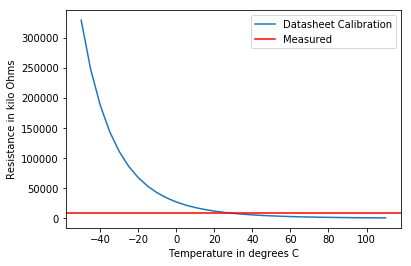

In [43]:
plt.plot(tt, r103AT, label='Datasheet Calibration');
plt.axhline(Rt, color='r', label='Measured')
plt.xlabel('Temperature in degrees C');
plt.ylabel('Resistance in kilo Ohms');
plt.legend();

In [51]:
Rt

9087.890966276429

In [52]:
nearest = min(range(len(r103AT)), key=lambda i: abs(r103AT[i]-Rt))
nearest

16

In [53]:
for di in [-1, 0, 1]:
    i = nearest + di
    print(tt[i], r103AT[i])

25 10000.0
30 8313.0
35 6940.0


In [50]:
min(enumerate(r103AT), key=lambda x: abs(x[1]-Rt))

(16, 8313.0)

In [54]:
def sh_coefficients(t1, r1, t2, r2, t3, r3):
    t1 =+ 273
    t2 =+ 273
    t3 =+ 273

    L1 = log(r1)
    L2 = log(r2)
    L3 = log(r3)

    Y1 = 1 / t1
    Y2 = 1 / t2
    Y3 = 1 / t3

    V2 = (Y2 - Y1) / (L2 - L1)
    V3 = (Y3 - Y1) / (L3 - L1)

    C = ((V3 - V2) / (L3 - L2)) * ((L1 + L2 + L3)**-1)
    B = V2 - C * (L1**2 + L1 * L2 + L2**2)
    A = Y1 - L1 * (B + C * L1**2)
    return A, B, C

In [33]:
t1 = 10
r1 = 17.96 *1000
t2 = 20
r2 = 12.09 * 1000
t3 = 40
r3 = 5.827 * 1000

t1 =+ 273
t2 =+ 273
t3 =+ 273

L1 = log(r1)
L2 = log(r2)
L3 = log(r3)

Y1 = 1 / t1
Y2 = 1 / t2
Y3 = 1 / t3

V2 = (Y2 - Y1) / (L2 - L1)
V3 = (Y3 - Y1) / (L3 - L1)

C = ((V3 - V2) / (L3 - L2)) * ((L1 + L2 + L3)**-1)
B = V2 - C * (L1**2 + L1 * L2 + L2**2)
A = Y1 - L1 * (B + C * L1**2)

tK = steinhart_hart_equation(Rt, A, B, C)
print(Rt)
print(A, B, C)
print(Rt)
tC = kelvin_to_celcius(tK)
print('Measured temperature: {} C'.format(tC))

10153.108282604686
0.003663003663003663 0.0 -0.0
10153.108282604686
Measured temperature: -0.14999999999997726 C


In [ ]:
a = 0.000811290160145459
b = 0.000211355789144265
c = 7.17614730463848e-08

tK = steinhart_hart_equation(Rt, a, b, c)
kelvin_to_celcius(tK)

In [ ]:
samples = 20

In [ ]:
data = []
for _ in range(samples):
    data.append([get_time()] + dev.get(sid='thermistor_test_' + str(_)))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.head()

In [ ]:
df['Rt'] = df.iloc[:,2].apply(lambda Vt: R2(R1=10000, Vin=Vcc, Vout=Vt))

In [ ]:
df['T'] = df.Rt.apply(lambda Rt: kelvin_to_celcius(steinhart_hart_equation(Rt, a, b, c)))

In [ ]:
df['T'].plot();